# Planetary Nebula Production <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pymuse.packages import *

from pymuse.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]

with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)
    
result = ascii.read(basedir/'data'/'interim'/ 'results.txt',format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
result.add_index('name')
result.rename_columns(['mu','mu+','mu-','mu_SNR','mu_SNR+','mu_SNR-'],['dis','dis_plus','dis_minus','dis_SNR','dis_SNR_plus','dis_SNR_minus'])

## Plot all objects in one figure

### Measure distance to all objects

In [ ]:
from pymuse.analyse import MaximumLikelihood1D, pnlf

result = {
'gal_name' : [],
'dis' : [],
'dis_plus' : [],
'dis_minus' : [],
'dis_SNR' : [],
'dis_SNR_plus' : [],
'dis_SNR_minus' : [],
'N_PN' : [],
'N_SNR' : [],
'N_SNRorPN' : []
}

for name in galaxies:
    result['gal_name'].append(name)
    
    completeness = parameters[name]['completeness_limit']
    
    filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
    tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')
    tbl['SNRorPN'] = [True if s=='True' else False for s in tbl['SNRorPN']]
    
    data = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['mOIII']
    err  = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['dmOIII']
    #data = data[data>26]
    
    if 'cut' in parameters[name]:
        print(f'removing points brighter than {parameters[name]["cut"]}')
        data = data[data>parameters[name]['cut']]
    
    fitter = MaximumLikelihood1D(pnlf,
                                 data,
                                 err=err,
                                 mhigh=completeness,
                                 Mmax=-4.53)
    
    # a good guess would be mu_guess = min(data)-Mmax
    mu,mp,mm = fitter([24])
    
    result['dis'].append(mu)
    result['dis_plus'].append(mp)
    result['dis_minus'].append(mm)
              
    result['N_PN'].append(len(data))
    result['N_SNR'].append(len(tbl[(tbl['type']=='SNR') & (tbl['mOIII']<completeness)]))
    result['N_SNRorPN'].append(np.sum(tbl['SNRorPN'] & (tbl['mOIII']<completeness)))
    #distances_measured[name] = fitter([24])
    
    data = tbl[((tbl['type']=='PN') | (tbl['SNRorPN'])) & (tbl['mOIII']<completeness)]['mOIII']
    err  = tbl[((tbl['type']=='PN') | (tbl['SNRorPN'])) & (tbl['mOIII']<completeness)]['dmOIII']
              

    if 'cut' in parameters[name]:
        print(f'removing points brighter than {parameters[name]["cut"]}')
        data = data[data>parameters[name]['cut']]
    
    fitter = MaximumLikelihood1D(pnlf,
                                 data[data<completeness],
                                 mhigh=completeness)
    
    # a good guess would be mu_guess = min(data)-Mmax
    #distances_measured[f'{name}_SNR'] = fitter([24])
    mu,mp,mm = fitter([24])
    result['dis_SNR'].append(mu)
    result['dis_SNR_plus'].append(mp)
    result['dis_SNR_minus'].append(mm)
            

In [ ]:
result['dis_Mpc'] = Distance(distmod=result['dis'])
result['dis_Mpc_plus'] = Distance(distmod=result['dis']+result['dis_plus']) - result['dis_Mpc']
result['dis_Mpc_minus'] = result['dis_Mpc']-Distance(distmod=result['dis']-result['dis_minus'])

result['dis_SNR_Mpc'] = Distance(distmod=result['dis_SNR'])
result['dis_SNR_Mpc_plus'] = Distance(distmod=result['dis_SNR']+result['dis_SNR_plus']) - result['dis_SNR_Mpc']
result['dis_SNR_Mpc_minus'] = result['dis_SNR_Mpc']-Distance(distmod=result['dis_SNR']-result['dis_SNR_minus'])

In [ ]:
# save to file
for col in ['dis','dis_plus','dis_minus','dis_Mpc','dis_Mpc_plus','dis_Mpc_minus']:
    result[col].info.format = '%.2f'

distance_modulus = []
distance_parsec = []
for row in result:
    distance_modulus.append(f'{row["dis"]:.2f} + {row["dis_plus"]:.2f} - {row["dis_plus"]:.2f}')
    distance_parsec.append(f'{row["dis_Mpc"]:.2f} + {row["dis_Mpc_plus"]:.2f} - {row["dis_Mpc_plus"]:.2f}')
result['mu'] = distance_modulus
result['d/Mpc'] = distance_parsec
                           
filename = basedir / 'data' / 'catalogues' / f'all_objects.txt'
with open(filename,'w',newline='\n') as f:
    ascii.write(result[['gal_name','mu','d/Mpc']],
                f,format='fixed_width',delimiter='\t',overwrite=True)

In [ ]:
tbl_out = ''
for row in result:
    tbl_out += f'{row["name"]} & {row["N_PN"]} & {row["N_SNR"]} ({row["N_SNRorPN"]}) '
    tbl_out += f'& $\\uncertainty{{{row["dis"]:.3f}}}{{{row["dis_plus"]:.3f}}}{{{row["dis_minus"]:.3f}}}$ '
    tbl_out += f'& $\\uncertainty{{{row["dis_Mpc"]:.3f}}}{{{row["dis_Mpc_plus"]:.3f}}}{{{row["dis_Mpc_minus"]:.3f}}}$ '
    tbl_out += f'& $\\uncertainty{{{row["dis_SNR"]:.3f}}}{{{row["dis_SNR_plus"]:.3f}}}{{{row["dis_SNR_minus"]:.3f}}}$ '
    tbl_out += f'& $\\uncertainty{{{row["dis_SNR_Mpc"]:.3f}}}{{{row["dis_SNR_Mpc_plus"]:.3f}}}{{{row["dis_SNR_Mpc_minus"]:.3f}}}$\\\\\n'
    
    
print(tbl_out)    

In [ ]:
def uncertainties(mu,mu_plus,mu_minus):
    d       = Distance(distmod=mu)
    d_plus  = Distance(distmod=mu+mu_plus) - Distance(distmod=mu)
    d_minus = Distance(distmod=mu)-Distance(distmod=mu-mu_minus)
    
    return d,d_plus,d_minus

### Plot PNLF

no catalogue for NGC1300
no catalogue for NGC1385
no catalogue for NGC1433
no catalogue for NGC1566
no catalogue for NGC4303
no catalogue for NGC4321
no catalogue for NGC7496


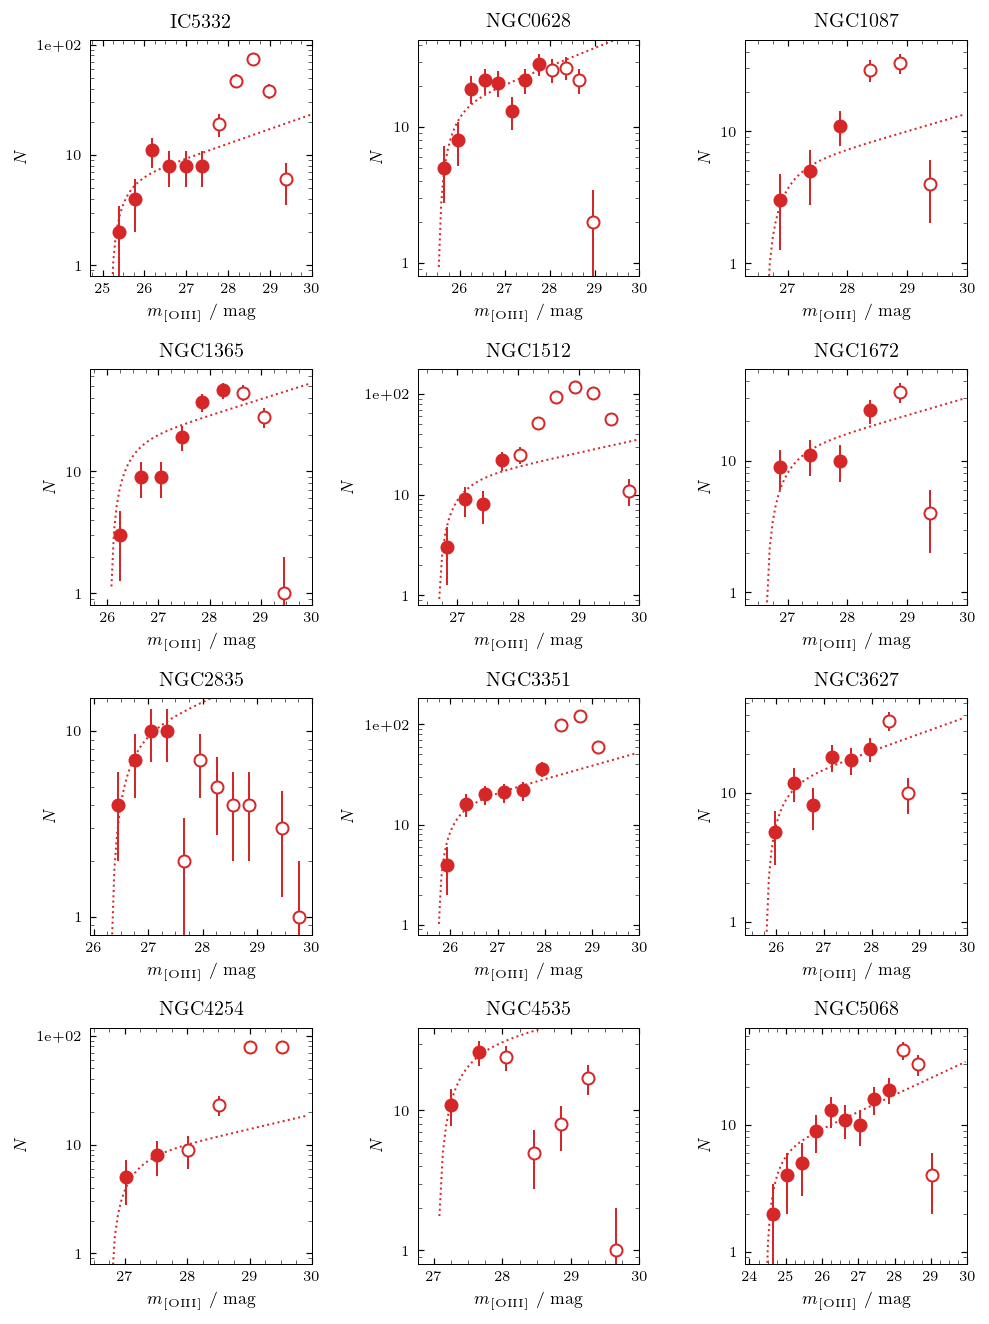

In [6]:
from pymuse.analyse import PNLF

Mmax = -4.47
names = result['name']

color = 'tab:red'

nrows = 4
ncols = 3
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes = iter(axes.flatten())

for name in names:  
    
    catalogue_file = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    if catalogue_file.is_file():
        try:
            catalogue = ascii.read(catalogue_file,format='fixed_width',delimiter='\t')
        except: 
            catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
        catalogue['exclude'] = catalogue['exclude'].astype(bool)
        
    else:
        print(f'no catalogue for {name}')
        continue
    
    # get the next axis
    ax = next(axes)

    data = catalogue[(catalogue['type']=='PN') & (~catalogue['exclude'])]['mOIII']
    mu = result.loc[name]['dis']
    completeness = parameters[name]['completeness_limit']
    binsize = parameters[name]['binsize']
        
    mlow = Mmax+mu
    mhigh = 30

    N = len(data[data<completeness])
    
    hist, bins  = np.histogram(data,np.arange(mlow,mhigh,binsize),density=False)
    err = np.sqrt(hist)
    # midpoint of the bins is used as position for the plots
    m = (bins[1:]+bins[:-1]) / 2
    
    # for the fit line we use a smaller binsize
    binsize_fine = 0.05
    bins_fine = np.arange(mlow,mhigh,binsize_fine)
    m_fine = (bins_fine[1:]+bins_fine[:-1]) /2

    # scatter plot
    ax.errorbar(m[m<completeness],hist[m<completeness],yerr=err[m<completeness],
                 marker='o',ms=6,mec=color,mfc=color,ls='none',ecolor=color)
    ax.errorbar(m[m>=completeness],hist[m>=completeness],yerr=err[m>completeness],
                 marker='o',ms=6,mec=color,mfc='white',ls='none',ecolor=color)
    ax.plot(m_fine,binsize/binsize_fine*N*PNLF(bins_fine,mu=mu,mhigh=completeness),c=color,ls='dotted')
    #ax.axvline(completeness,c='black',lw=0.2)
    #ax.axvline(mu+Mmax,c='black',lw=0.2)

    # adjust plot
    ax.set_yscale('log')
    ax.set_xlim([1.1*mlow-0.1*mhigh,mhigh])
    ax.set_ylim([0.8,1.5*np.max(hist)])
    ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    ax.set_ylabel(r'$N$')
    
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.set_title(name)
    
plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_PNLF'
#plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.show()

### Plot cumulative PNLF

no catalogue for NGC1300
no catalogue for NGC1385
no catalogue for NGC1433
no catalogue for NGC1566
no catalogue for NGC4303
no catalogue for NGC4321
no catalogue for NGC7496


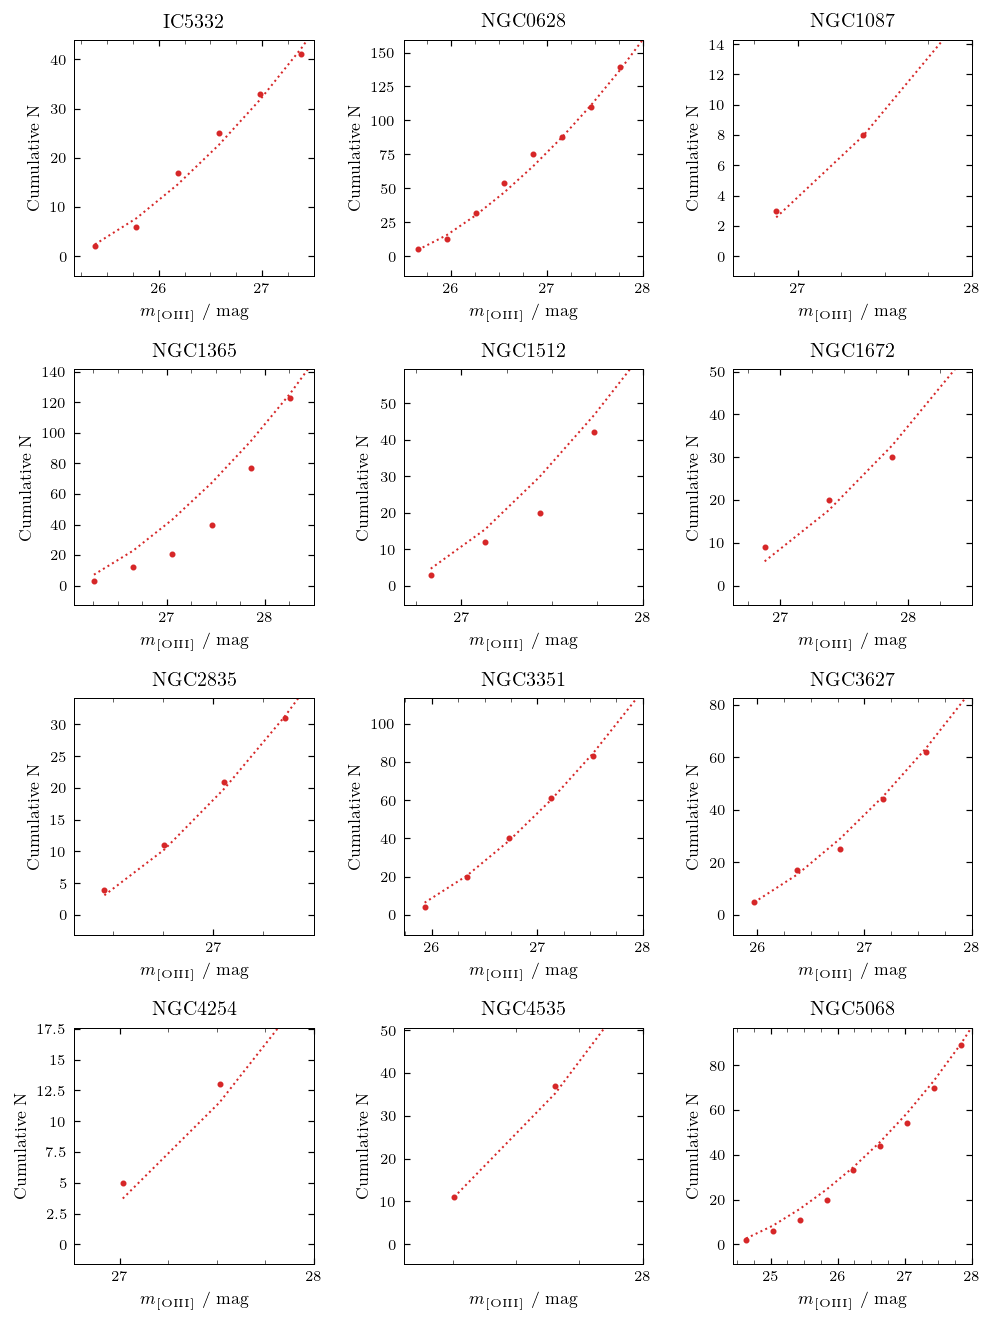

In [12]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf

binsize=0.1
Mmax = -4.47
color = 'tab:red'

nrows = 4
ncols = 3
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes = iter(axes.flatten())

for name in names:  
    
    catalogue_file = basedir / 'data' / 'catalogues' / f'{name}_nebulae.txt'
    if catalogue_file.is_file():
        try:
            catalogue = ascii.read(catalogue_file,format='fixed_width',delimiter='\t')
        except: 
            catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
        catalogue['exclude'] = catalogue['exclude'].astype(bool)
        
    else:
        print(f'no catalogue for {name}')
        continue
    
    # get the next axis
    ax = next(axes)
    
    data = catalogue[(catalogue['type']=='PN') & (~catalogue['exclude'])]['mOIII']
    mu = result.loc[name]['dis']
    completeness = parameters[name]['completeness_limit']
    binsize = parameters[name]['binsize']
    
    mlow = Mmax+mu
    mhigh = 32

    N = len(data[data<completeness])
    
    hist, bins  = np.histogram(data,np.arange(mlow,mhigh,binsize),density=False)
    err = np.sqrt(hist)
    # midpoint of the bins is used as position for the plots
    m = (bins[1:]+bins[:-1]) / 2
    
    # for the fit line we use a smaller binsize
    binsize_fine = 0.01
    bins_fine = np.arange(mlow,mhigh,binsize_fine)
    m_fine = (bins_fine[1:]+bins_fine[:-1]) /2

    # scatter plot
    data.sort()
    #ax.plot(data,np.arange(1,len(data)+1,1),ls='none',mfc=color,mec=color,ms=2,marker='o')
    ax.plot(m[m<completeness],np.cumsum(hist[m<completeness]),ls='none',mfc=color,mec=color,ms=2,marker='o')
    #data.sort()
    #ax.plot(data,np.arange(1,len(data)+1,1),ls='none',mfc=color,mec=color,ms=1.5,marker='o')
    ax.plot(m,N*np.cumsum(PNLF(bins,mu=mu,mhigh=completeness)),ls='dotted',color=color)

    # adjust plot    
    ax.set_xlim([mlow,completeness])
    ax.set_ylim([-0.1*N,1.1*N])
    ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    ax.set_ylabel(r'Cumulative N')
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y)))
    ax.set_title(name)
    
plt.tight_layout()
filename = basedir / 'reports' / f'all_objects_PNLF_cum'
#plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.show()

In [14]:
import collections